# Prediction of Remaining Useful Life (RUL)
To predict the RUL of the various units of the CMAPSS data, we will create an LSTM to define the RUL. As we focus on the RUL of synthetic data compared to CMAPSS, we use the approach of [related work](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_LSTM_piecewise_linear_degradation_model.ipynb) to construct our LSTM. Also, the notebook of [Pramod Bendigeri](https://github.com/ben7pram/ddm-fl-project-2023/blob/main/centralised-learning/CMAPSS%20-%20Centralized.ipynb) served as inspiration for this code notebook.

In [1]:
# import various modules and packages
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Preprocessing the data
Before we train on the CMAPSS data, we want to preprocess the data. Preprocessing prevents vanishing/exploding gradients by normalising features and removing empty inputs. 

First, we load the .txt file and rename the columns according to their description in the CMAPSS data set. Following this, we save the output as .csv and show the new file.

In [2]:
# rename columns according to readme.txt
indexes = ["unit_nr", "timecycle"]
op_settings = ["ops_set1", "ops_set2", "ops_set3"]
sensors = []

for i in range(1,22):
    sensors.append(f"sens_{i}")
    
col_names = indexes + op_settings + sensors

# read data
train = pd.read_csv(('./CMAPSS/train_FD001.txt'), sep='\s+', header=None, names=col_names)
test_data = pd.read_csv(('./CMAPSS/test_FD001.txt'), sep='\s+', header=None, names=col_names)
test_labels = pd.read_csv(('./CMAPSS/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# # show train set
# train

### RUL
This data set does not contain the RUL target value. However, it does contain the amount of timecycles for each unit-nr until the engine does not work anymore. Because we know how many occurences we have for each unit-nr, we can compute the RUL by counting the amount of timecycles for each unique unit-nr.

In [3]:
# Compute Remaining Useful Life (RUL) for each index (engine)
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["timecycle"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["timecycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)

## Plotting the histogram of RUL per index

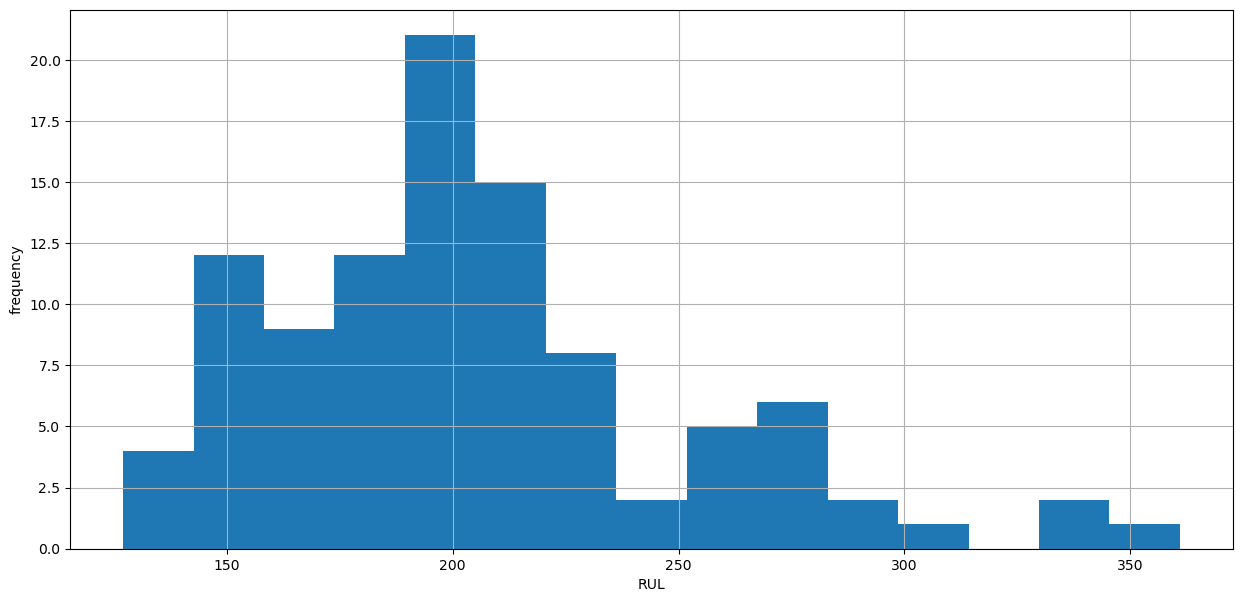

In [4]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

This figure clearly shows that the data is skewed to the right, if we look at the mean RUL. We see that the average RUL lies around 200. To ensure that, we compute the mean and standard deviation of the RUL per index. We strive for the 95% confidence interval, and so all values with more than 2 standard deviations from the mean are deemed as errors.

In [5]:
# compute and print mean & std
mean_RUL = df_max_rul['RUL'].mean()
std_RUL = round(df_max_rul['RUL'].std(), 2)

print(f"Mean RUL: {mean_RUL}, standard deviation: {std_RUL}")
print(f"So all RUL values 2 times above standard deviation, {mean_RUL - 2 * std_RUL} < RUL < {mean_RUL + 2 * std_RUL}, can be discarded.")

Mean RUL: 205.31, standard deviation: 46.34
So all RUL values 2 times above standard deviation, 112.63 < RUL < 297.99, can be discarded.


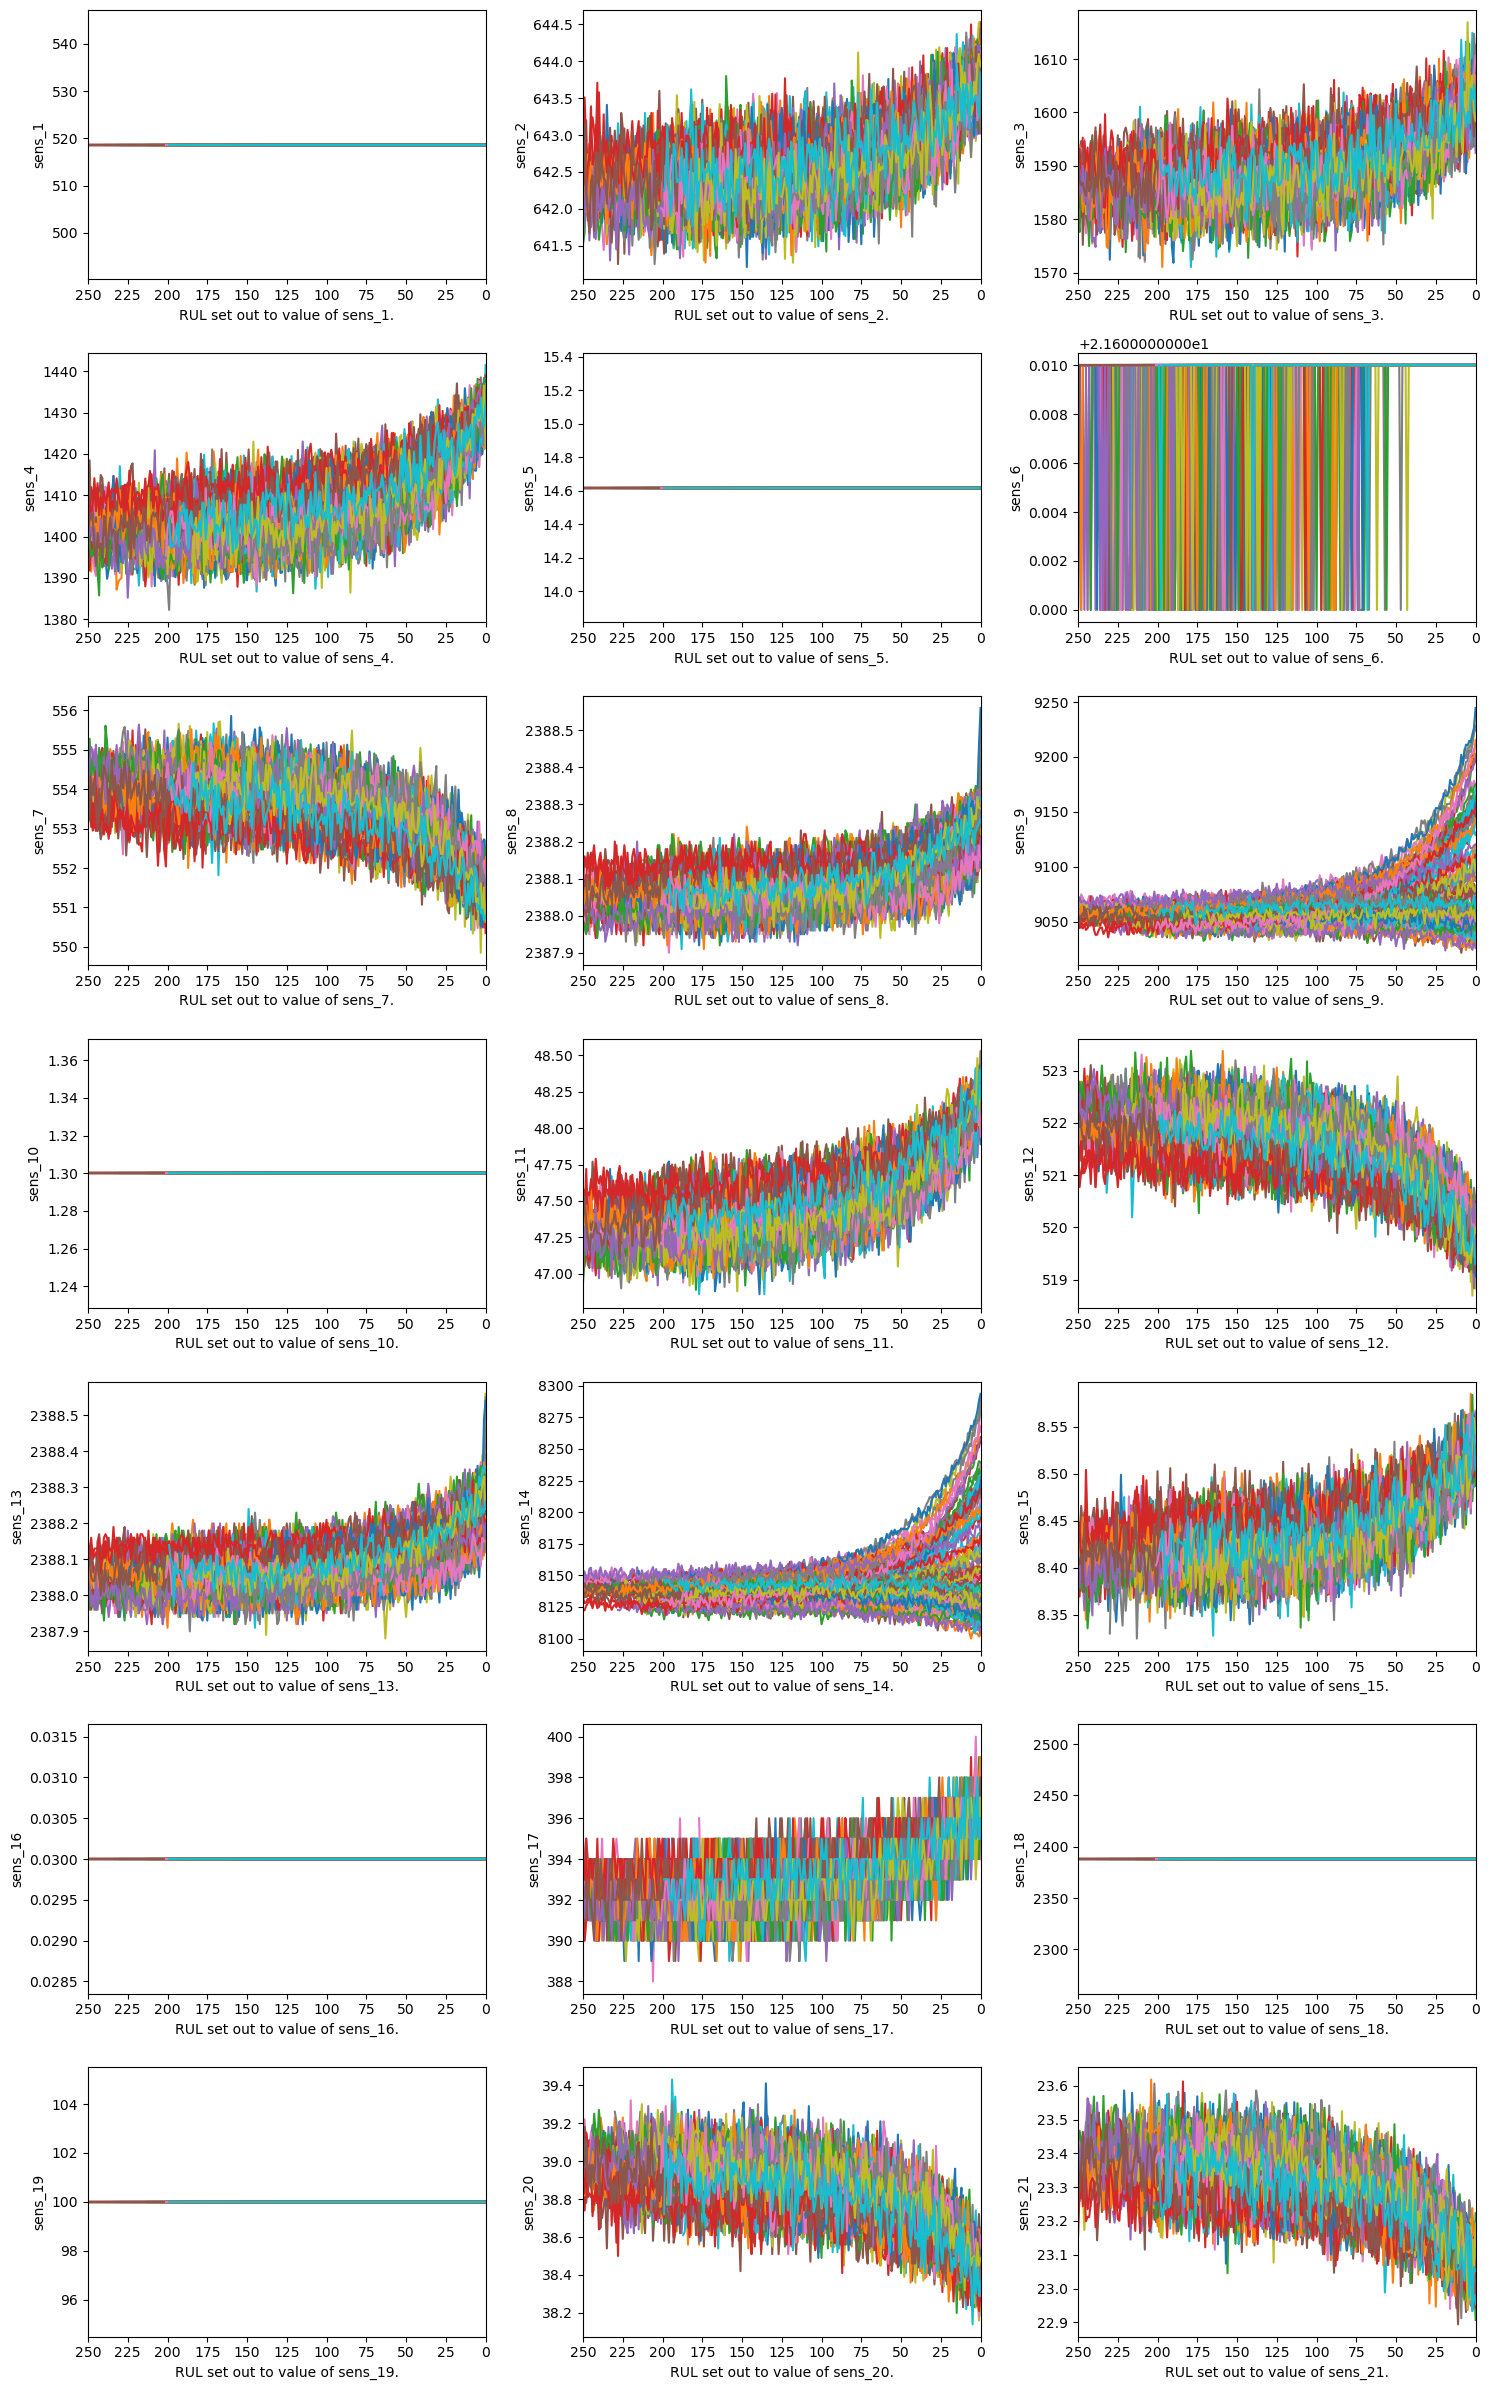

In [6]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 24))

for i, sensor_idx in enumerate(sensors):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    # plot each sensor in own graph
    for j in train['unit_nr'].unique():
        ax.plot('RUL', sensor_idx, data=train[train['unit_nr']==j])
    
    # graphics
    ax.set_xlim(250, 0)
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_idx)
    ax.set_xlabel(f'RUL set out to value of {sensor_idx}.')

plt.tight_layout()
plt.savefig('./Figures/Expected')

It seems that in the data there are some columns which have a constant value. Using an exploratory data analysis we can try to find these values. 

## We could consider clipping first 125 cycles out
Also, similiar to [earlier work](https://github.com/ben7pram/ddm-fl-project-2023/blob/main/centralised-learning/CMAPSS%20-%20Centralized.ipynb) we will clip the first 125 cycles out as these are deemed irrelevant

### Constant values
As expected we see some columns with a standard deviation of 0. Specifically, sensors 1, 5, 6, 10, 16, 18 and 19 seem irrelevant for the prediction task as they have really small standard deviations. We can then conclude that these parameters are likely irrelevant for the prediction task. And so we will take them out.

In [7]:
train.describe().T['std']
train

,unit_nr,timecycle,ops_set1,ops_set2,ops_set3,sens_1,sens_2,sens_3,sens_4,sens_5,...,sens_13,sens_14,sens_15,sens_16,sens_17,sens_18,sens_19,sens_20,sens_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [8]:
print("Train set after removal of constant values:")
const_cols = ['sens_1', 'sens_5', 'sens_6', 'sens_10', 'sens_16', 'sens_18', 'sens_19']
cols_to_drop = indexes + op_settings + const_cols

train = train.drop(cols_to_drop, axis=1)
train

Train set after removal of constant values:


,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


# On to prediction!

In [9]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [10]:
# remove RUL from training data, split
train_data = train.drop('RUL', axis=1) # data without constants
train_labels = train.pop('RUL') # RUL values

# Since the true RUL values for the test set are only provided for the last time cycle of each engine, 
# the test set is subsetted to represent the same
test_data = test_data.groupby('unit_nr').last().reset_index().drop(cols_to_drop, axis=1)

# # check whether RUL and constant columns removed
# X_test

# Random Forest regression

In [11]:
rf = RandomForestRegressor()

rf.fit(train_data, train_labels)

# predict and evaluate
pred_train = rf.predict(train_data)
evaluate(pred_train, train_labels, 'train')

pred_test = rf.predict(test_data)
evaluate(pred_test, test_labels)

train set RMSE:15.64637329280428, R2:0.9345003045791109
test set RMSE:33.116131703446285, R2:0.6264548240142399


## Clipping
Compared to related work, the RMSE is rather high. We can clip the first 125 engine cycles as these often show little to no degradation. This could decrease the RMSE:

In [12]:
train_data_clipped = train_data.clip(upper=125)
train_labels_clipped = train_labels.clip(upper=125)

rf_clip = RandomForestRegressor()

rf_clip.fit(train_data_clipped, train_labels_clipped)

print("Predicting with clipped training data, without clipping test data:")
# predict and evaluate
pred_train = rf_clip.predict(train_data_clipped)
evaluate(pred_train, train_labels_clipped, 'train')

pred_test = rf_clip.predict(test_data)
evaluate(pred_test, test_labels)

# And now when also clipping the test data
print("\nClipping also the test data:")
test_data_clipped = test_data.clip(upper=125)
test_labels_clipped = test_labels.clip(upper=125)

rf_clip2 = RandomForestRegressor()

rf_clip2.fit(train_data_clipped, train_labels_clipped)

# predict and evaluate
pred_train = rf_clip2.predict(train_data_clipped)
evaluate(pred_train, train_labels_clipped, 'train clipped')

pred_test = rf_clip2.predict(test_data_clipped)
evaluate(pred_test, test_labels_clipped)

Predicting with clipped training data, without clipping test data:
train set RMSE:8.799208481154341, R2:0.9456535031699796
test set RMSE:22.931405299283337, R2:0.584113593729193

Clipping also the test data:
train clipped set RMSE:8.78986989698776, R2:0.9457487033520455
test set RMSE:22.173012131868777, R2:0.6015699960544594
